# Tutorial

In this tutorial, we demonstrate how Summit can be used to optimise reactions automatically. 


Summit introduces two key concepts: **benchmarks** and **strategies**. Benchmarks are simulations of reactions, and strategies are ML algorithms used to choose experiments. Two benchmarks are already implemented, and it is easy to add more. We are going to optimise a nucleophilic aromatic substitution (SnAr) benchmark.

Summit provides access to six different optimisation strategies. And, it gives a common interface, so you can easily switch between strategies. We'll see that soon.


## Google Colab

If you would like to follow along with this tutorial, you can open it in Google Colab using the button below.

{{ badge }}

You will need to run the following cell to make sure Summit and all its dependencies are installed. If prompted, restart the runtime.

In [ ]:
!pip install git+https://github.com/sustainable-processes/summit.git#egg=summit

## SnAr Benchmark


![Image from Hone et al.](_static/hone_2016_snar_chemistry.png)

Nucleophilic aromatic substitution reactions are commonly used in the fine chemicals industry. <!--Something about their frequncy from the Journal of medicinal chemistry letters paper --> In this case, 2,4 dinitrofluorobenzene (**1**) undergoes nucleophilic attack by pyrrolidine (**2**) to form the desired product **3**. Two side products **4** and **5** can also be formed. Overall, we want to maximise the amount of product formed and minimise side product formation and waste.

The kinetics of this reaction were published by [Hone et al.](http://xlink.rsc.org/?DOI=C6RE00109B) We imagine a scenario where this reaction is to be optimised in a flow reactor. We have set up a "virtual" flow chemistry reactor in the `SnarBenchmark` using the published kinetics and standard chemical engineering equations. You simply supply the reaction conditions to `SnarBenchmark` and it will give back the results of a virtual reaction with those conditions. Think of it as your virtual experiment.

Below, we start importing the needed packages and setting up the `SnarBenchamrk`.

In [2]:
from summit import Runner
from summit.strategies import Random, SOBO, MultitoSingleObjective
from summit.benchmarks import SnarBenchmark
from summit.utils.dataset import DataSet
import matplotlib.pyplot as plt

In [2]:
exp = SnarBenchmark()
exp.domain

Name,Type,Description,Values
tau,"continuous, input",residence time in minutes,"[0.5,2]"
equiv_pldn,"continuous, input",equivalents of pyrrolidine,"[1.0,5]"
conc_dfnb,"continuous, input","concentration of 2,4 dinitrofluorobenenze at reactor inlet (after mixing) in M","[0.1,0.5]"
temperature,"continuous, input",Reactor temperature in degress celsius,"[30,120]"
sty,"continuous, maximize objective",space time yield (kg/m^3/h),"[0,100]"
e_factor,"continuous, minimize objective",E-factor,"[0,10]"


We print out the `domain` which describes the optimisation problem associated with `SnarBenchmark`.  The objectives are to maximize space-time yield (STY) and minimize E-factor. STY is the mass of product produced per reactor volume per time, and E-factor is the ratio of the mass of waste to mass of product. Waste is the amount of side product (**4** and **5**), unreacted starting material and solvent produced in the reactor outlet stream. By minimising E-factor, we are effectively maximising selectivity and reaction "greeness" at the same time. 

We optimize the reactions by changing the residence time, inlet concentration of 2,4-dinitrofluorobenzene (**1**), equivalences of of pyrrolidine (**2**), and temperature. 

### Running a single experiment

Before we do any optimization, let's get a sense of how our virtual laboratory works. Below, we run one virtual experiment with relatively mild conditions (residence time = 0.5 minutes, equiv of **2** = 1.5, concentration of **1** = 0.1 M and T = 30.0°C).

In [3]:
# Create some test conditions
columns = [v.name for v in exp.domain.variables]
values  =   {('tau', 'DATA'): 1.5,  # minutes
             ('equiv_pldn', 'DATA'): 0.5,  
             ('conc_dfnb', 'DATA'): 0.1, #molar
             ('temperature', 'DATA'): 30.0, # degrees celsius
            }
conditions = DataSet([values], columns=columns)

# Run the conditions
exp.reset()
results = exp.run_experiments(conditions)
results.round(2)

,tau,equiv_pldn,conc_dfnb,temperature,sty,e_factor,computation_t,experiment_t,strategy
0,1.5,0.5,0.1,30.0,168.96,191.26,0.0,0.01,NaN


In the above code, we put our reaction conditions in a summit DataSet, which is a Pandas dataframe that allows us to specify certain columns as metadata. For example, the experiment time column is a metadata column. That's why the values dictionary has tuples that specify the type of columns (DATA vs. METADATA).  

We run the virtual experiment using `exp.run_experiments`, which integrates the kinetic equations at the conditions given. The results are printed out.

We can see that these conditions give a very low space-time yield (a good value would be around >10,000 kg/m^3/h) and high E-factor (a good value would be <10).  So, let's try to optimze the conditions. 

### Random Strategy

In Summit, methods for optimizing reactions are called strategies. There are six strategies available, each with different capabilities. The advantage of using Summit is that we can quickly and easily test out different strategies on a problem to see which one performs best. 

We are going to first use a random strategy as a baseline, where each experiment is selected at random. Any advanced strategies should at least perform better than this.

Note that in order to see the progress bar in jupyter, you'll need to install the jupyter or jupyterlab extension for ipywidgets. See [here](https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-the-jupyterlab-extension) for details.

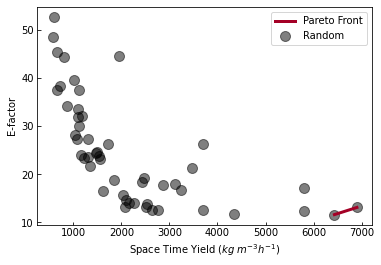

In [4]:
#Set up the experiment
exp = SnarBenchmark()

# Instantiate random sampling strategy
strategy = Random(exp.domain)

# Use the runner to run closed loop optimisation
r = Runner(strategy=strategy, experiment=exp, max_iterations=50)
r.run()

# Plot the results
fig, ax = exp.pareto_plot()
_ = ax.set_xlabel('Space Time Yield ($kg \; m^{-3} h^{-1}$)')
_ = ax.set_ylabel('E-factor')

In the above code, we start by creating the laboratory as we did before. We then setup the random strategy using `Random`and ask it for experiments using `suggest_experiments`. We run those experiments and plot the results. 

The above plot is a pareto plot. Each point in the above plot represents the objective values for a different set of reaction conditons. The pareto front shows the conditions that optimize space-time yield at the cost of E-factor and vice versa. 

### SOBO Strategy

Now, let's see if we can do better by using machine learning.  We will use the Single-Objective Bayesian optimisation (SOBO) strategy. This builds a model of the objective.

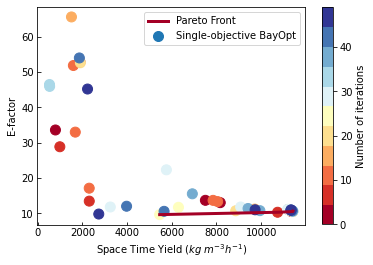

In [5]:
exp = SnarBenchmark()

# Since the Snar benchmark has two objectives and Nelder-Mead is single objective, 
# we need a multi-to-single objective transform
transform = MultitoSingleObjective(
    exp.domain, expression="-sty/1e4+e_factor/100", maximize=False
)

# Set up the strategy, passing in the optimisation domain and transform
strategy = SOBO(exp.domain, transform=transform)

# Use the runner to run closed loop optimisation
r = Runner(
    strategy=strategy, experiment=exp,max_iterations=50
)
r.run()

# Plot the results
fig, ax = exp.pareto_plot(colorbar=True)
_ = ax.set_xlabel('Space Time Yield ($kg \; m^{-3} h^{-1}$)')
_ = ax.set_ylabel('E-factor')

The code above is very similar to the random sampling code with one major addition. We use the `MultitoSingleObjective` transform since `SnarBenchmark` has two objectives, but `SOBO` can only optimise one objective. `MultitoSingleObjective` takes an expression that creates scalar value from the objectives. You simply use the names of the objectives and any expressions compatible with [Pandas eval](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.eval.html). Now, let's see the optimal conditions. 

In [7]:
exp.pareto_data.round(2)

,tau,equiv_pldn,conc_dfnb,temperature,sty,e_factor,computation_t,experiment_t,strategy
25,1.04,1.67,0.5,45.67,5456.65,9.65,0.58,0.01,Single-objective BayOpt
7,0.50,1.86,0.5,45.93,10739.98,10.31,0.31,0.01,Single-objective BayOpt
17,0.50,4.00,0.5,45.25,11421.57,10.51,0.48,0.01,Single-objective BayOpt
33,0.50,4.34,0.5,42.80,11430.01,10.63,0.54,0.01,Single-objective BayOpt


## From Virtual to Real Experiments

In addition to running virtual experiments using benchmarks, Summit can be used to optimise real experiments. We will demonstrate how you might do that in this section. First, some imports:

In [13]:
from summit import Runner
from summit.strategies import SOBO, MultitoSingleObjective
from summit.benchmarks import SnarBenchmark
from summit.utils.dataset import DataSet
import pathlib

If you are running this yourself, uncomment the second line.

In [8]:
FOLDER = pathlib.Path("_static/")  # When using this in the context of docs
# FOLDER = pathlib.Path(".")

### Running Experiments Manually

 There is a simple set of commands that allows you to do this. Let's say we are going to run the SnarBenchmark manually instead of in a closed-loop setup. We'll use SOBO to demonstrate.

In [9]:
# We are just going to get the domain from the SnarBenchmark
exp = SnarBenchmark()

transform = MultitoSingleObjective(
    exp.domain, expression="-sty/1e4+e_factor/100", maximize=False
)

# Instantiate SOBO
strategy = SOBO(exp.domain, transform=transform)

# To get the first experiments
next_experiments = strategy.suggest_experiments(2)
next_experiments

,tau,equiv_pldn,conc_dfnb,temperature,strategy
0,1.697277,2.376661,0.494231,81.356964,Single-objective BayOpt
1,1.934914,3.721557,0.288667,33.054666,Single-objective BayOpt


Since it might be a while before we come back, let's save what we've done up until now. We save a file called `snar_sobo_external.json` which contains all of the information we need to reproduce our work up to this point.  We will also produce a CSV with the suggested conditions, which we can use to record the results of our experiments. 

In [10]:
# Save SOBO hyperparameters and internal state
strategy.save(FOLDER / 'snar_sobo_external.json')

# Save experiments to CSV
next_experiments.to_csv(FOLDER / 'snar_experiments_external_0.csv')

Normally, we would now go and run the experiments separately and add a column for sty and yield with our results. We could do that in Excel. However, since this is just a demonstration, we'll simulate the experiments using the SnarBenchmark class and save the results to a CSV. 

In [11]:
# "Run" the experiments and save to CSV.
results = exp.run_experiments(next_experiments)
results.to_csv(FOLDER / 'snar_experiments_external_1.csv')

Now that we have run the conditions, we can load SOBO and the data back in from the files we saved.

In [14]:
# Load in previous TSEMO hyperparameters and internal state
strategy = SOBO.load(FOLDER / 'snar_sobo_external.json')

# Load in experimental results
prev_res = DataSet.read_csv(FOLDER / 'snar_experiments_external_1.csv')
prev_res

,tau,equiv_pldn,conc_dfnb,temperature,sty,e_factor,computation_t,experiment_t,strategy
0,1.69728,2.37666,0.494231,81.357,2577.87,13.118,0,0.018846,Single-objective BayOpt
1,1.93491,3.72156,0.288667,33.0547,1694.33,16.5807,0,0.015223,Single-objective BayOpt


Now, we can run SOBO again and ask for new suggested conditions based on the first set of experiments.

In [15]:
# Get experimental suggestions from TSEMO
second_experiments = strategy.suggest_experiments(1, prev_res=prev_res)

# Save TSEMO state
strategy.save(FOLDER / 'snar_sobo_external_2.json')

# Save experiments to CSV
second_experiments.to_csv(FOLDER / 'snar_experiments_external_2.csv')
second_experiments

,tau,equiv_pldn,conc_dfnb,temperature,strategy
0,1.122319,3.164345,0.23599,34.448618,Single-objective BayOpt


We can repeat the the cycle of saving and loading the SOBO paramters and next experiments until we are satisfied with the results.

### Running Closed Loop Experiments

As you've seen above, Summit has special functionality for running closed-loop experiments.  The `Runner` class takes a strategy and experiment. It then get experiment suggestions from the strategy and runs the experiments.

If you have an automated experiment (e.g., a flow reactor), you can create your own Runner that sends requests to your experimental setup. As an example of how to do this, look at  [`NeptuneRunner`](https://github.com/sustainable-processes/summit/blob/8d64f6f7705392242619d8ca393281af1a9d7e97/summit/run.py#L219), which we created to log the results of benchmarks to [Neptune.ai](https://neptune.ai/) during our own work. Primarily you need to override the `run` method.
